In [1]:
import json
import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import math
import copy
from scipy.spatial import distance
from pathlib import Path
import scipy
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm.auto import tqdm
import json
import numpy as np
from skimage.io import imread, imshow
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd
from pathlib import Path
import os
import time
from functools import wraps

/home/hmi/anaconda3/envs/gt-depth-gen/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
via_bboxes_label_path = "../labels/sino_nom_labels/02125_mk3.json"
via_2d_3d_mapping_path = "../labels/via_labels/via_02125_mk3_depth_print_mapping.json"
registered_print_woodblock_path = "./woodblock_register_3d"
print_woodblock_path = "../data/models_3d/02125_surface_1.stl"
surface_point_of_woodblock_path = "../data/models_3d/02125_surface_1_surface_points.stl"
floor_point_of_woodblock_path = "../data/models_3d/02125_surface_1_floor.stl"
image_2d_path = "../data/images_2d/02125_mk3/tt4_ban_in_q15_mk3.jpg"
woodblock_id = "02125_mk3"
depth_path = "./woodblock_depth_map"

### 1. Get the cofficients of polynominal parametric surface

In [2]:
def get_character_plane(data, order=2):
    if order == 1:
        # best-fit linear plane z = a*x + b*y + c, where a, b, c are the cofficients that need to find
        # a = C[0], b = C[1], c = C[2]
        A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
        return [C[0], C[1], -1, C[2]]
    elif order == 2:
        # best-fit quadratic curve z = a + b*x + c*y + d*x*y + e*x*x + f*y*y
        # a = C[0], b = C[1], c= C[2], d = C[3], e = C[4], f = C[5]
        A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
        return [C[0], C[1], C[2], -1, C[3], C[4], C[5]]

### 2. Get the depth map from the stl model

In [3]:
def scale_to_z(a, min_depth, max_depth, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-z_scale
        Optionally specify the data type of the output (default is uint16)
    """
    bg_mask = np.full(a.shape, 255)
    img = (((a - min_depth) / float(max_depth - min_depth)) * 254)
    depth_img = np.where(a == np.inf, bg_mask, img)
    return depth_img.astype(dtype)

def get_spatial_limit_of_point_cloud(pc_mesh):
    np_vertices = np.asarray(pc_mesh.vertices)
    x_max = np.max(np_vertices[:, 0])
    x_min = np.min(np_vertices[:, 0])
    y_max = np.max(np_vertices[:, 1])
    y_min = np.min(np_vertices[:, 1])
    z_min = np.min(np_vertices[:, 2])
    z_max = np.max(np_vertices[:, 2])
    spatial_limit = {'x_max': x_max, 'x_min': x_min, 'y_max': y_max, 'y_min': y_min, 'z_min': z_min, 'z_max': z_max}
    return spatial_limit


def ray_tracing_depth_map(pc_mesh, side_range=(-12, 12), fwd_range=(-12, 12), res=(2000, 2000, 255), z_max_camera=10, max_z_distance=16):
    t_pc_mesh = o3d.t.geometry.TriangleMesh.from_legacy(pc_mesh)
    scene = o3d.t.geometry.RaycastingScene()
    character_id = scene.add_triangles(t_pc_mesh)
    side_width = side_range[1] - side_range[0]
    fwd_height = fwd_range[1] - fwd_range[0]
    ratio_width = side_width / res[0]
    ratio_height = fwd_height / res[1]
    x_range = side_range[0] + np.arange(res[0])*ratio_width
    y_range = fwd_range[0] + np.arange(res[1])*ratio_height
    x_mesh, y_mesh = np.meshgrid(x_range, y_range)
    x_mesh_flat = x_mesh.reshape((-1, ))
    y_mesh_flat = y_mesh.reshape((-1, ))
    z_mesh_flat = np.full((x_mesh_flat.shape[0], ), z_max_camera)
    direction = np.repeat(np.asarray([0, 0, -1]).reshape((1, -1)), z_mesh_flat.shape[0], axis=0)
    point_mesh = np.stack((x_mesh_flat, y_mesh_flat, z_mesh_flat), axis=1)
    rays = np.concatenate((point_mesh, direction), axis=1)
    rays = o3d.core.Tensor(rays, dtype=o3d.core.Dtype.Float32)
    ans = scene.cast_rays(rays)
    pixel_values = ans['t_hit'].numpy()
    pixel_values = pixel_values.reshape((res[0], res[1]))
    _, z_max_depth = -np.sort(-np.unique(pixel_values))[:2]
    
    z_min_depth = np.min(pixel_values)
    normalized_pixel_values = scale_to_z(pixel_values, z_min_depth, z_max_depth)
    img_inverted_matrix = np.array([[ratio_width, 0, 0, side_range[0]], [0, ratio_height, 0, fwd_range[0]], [0, 0, -max_z_distance/254.0, z_max_camera], [0, 0, 0, 1]])
    return img_inverted_matrix, normalized_pixel_values

def convert_pc_to_depth_map(stl_path, res=(12000, 12000, 255)):
    if isinstance(stl_path, str):
        pc_mesh = o3d.io.read_triangle_mesh(stl_path)
    else:
        pc_mesh = stl_path
    spatial_limit = get_spatial_limit_of_point_cloud(pc_mesh)
    y_length = spatial_limit["y_max"] - spatial_limit["y_min"]
    x_length = spatial_limit["x_max"] - spatial_limit["x_min"]
    # print(spatial_limit)
    if y_length > x_length:
        x_need = (y_length - x_length) / 2
        spatial_limit["x_min"] -= x_need
        spatial_limit["x_max"] += x_need
    else:
        y_need = (x_length - y_length) / 2
        spatial_limit["y_min"] -= y_need
        spatial_limit["y_max"] += y_need
    img_inverted_matrix, normalized_depth_img = ray_tracing_depth_map(pc_mesh,  side_range=(spatial_limit["x_min"], spatial_limit["x_max"]), fwd_range=(spatial_limit["y_min"], spatial_limit["y_max"]), res=res, z_max_camera=spatial_limit["z_max"] + 0.5, max_z_distance=spatial_limit["z_max"] - spatial_limit["z_min"] + 1)
    return img_inverted_matrix, normalized_depth_img

In [4]:
def read_json_file(json_path):
    with open(json_path, 'r') as f:
        content = json.load(f)
    return content

def write_json_file(anno, json_path):
    with open(json_path, 'w') as f:
        json.dump(anno, f)
        
def get_bboxes_from_via_anno_file(via_json_path, key_src='depth'):
    anno = read_json_file(via_json_path)
    dest_point_list = []
    src_point_list = []
    file_name_list = list(anno.keys())
    for anno_key in anno.keys():
        if key_src in anno_key:
            for point_info in anno[anno_key]['regions']:
                dest_point_list.append([point_info['shape_attributes']['cx'], point_info['shape_attributes']['cy']])
        else:
            for point_info in anno[anno_key]['regions']:
                src_point_list.append([point_info['shape_attributes']['cx'], point_info['shape_attributes']['cy']])
    return [src_point_list, dest_point_list]

def get_point_from_via_file(via_json_path):
    src_point_list, dest_point_list = get_bboxes_from_via_anno_file(via_json_path)
    np_src_point_list = np.asarray(src_point_list)
    np_dest_point_list = np.asarray(dest_point_list)
    return [np_src_point_list, np_dest_point_list]


def mapping(anno_register_file, np_src_point_list, np_dest_point_list):
    tform = transform.estimate_transform('projective', np_src_point_list, np_dest_point_list)
    anno = read_json_file(anno_register_file)
    bboxes_list = parse_sino_nom_bboxes(anno)  # parse_polybboxes(anno)
    np_bboxes = np.asarray(bboxes_list) 
    np_dest_bboxes = []
    for poly_points in np_bboxes:
        np_dest_bboxes.append(tform(poly_points))
    return [np_dest_bboxes, np_bboxes]

def parse_sino_nom_bboxes(anno_info):
    bboxes_info = anno_info["bboxes"]
    bboxes_list = []
    for bbox in bboxes_info:
        x_min, y_min, x_max, y_max = bbox["x_min"], bbox["y_min"], bbox["x_max"], bbox["y_max"]
        rect_box_points = np.asarray([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
        bboxes_list.append(rect_box_points)
    return bboxes_list

        
def parse_polybboxes(anno):
    poly_points = []
    for key, anno_info in anno.items():
        poly_info_list = anno_info["regions"]
        # print(poly_info_list[0])
        for poly_info in poly_info_list:
            x_point_list = poly_info["shape_attributes"]["all_points_x"]
            y_point_list = poly_info["shape_attributes"]["all_points_y"]
            points = np.stack((x_point_list, y_point_list), axis=-1)
            poly_points.append(points)
    return poly_points

### 3. Get Rotation matrix of plane such that the normalized vectors of the plane is the same direction as the unit vectors (0,0,1)

In [5]:
def calc_sin_phi(a, b, c):
    return sqrt((a*a + b*b) / (a*a + b*b + c*c))

def calc_cos_phi(a, b, c):
    return c / sqrt(a*a + b*b + c*c)

def calc_u1(a, b, c):
    return b / sqrt(a*a + b*b)


def calc_u2(a, b, c):
    return -a / sqrt(a*a + b*b)

def get_rotation_matrix(plane_coff):
    a, b, c, d = plane_coff
    cos_phi = calc_cos_phi(a, b, c)
    sin_phi = calc_sin_phi(a, b, c)
    u1 = calc_u1(a, b, c)
    u2 = calc_u2(a, b, c)
    rot_matrix = np.array([
        [cos_phi + u1 * u1 * (1 - cos_phi)  , u1 * u2 * (1 - cos_phi)           , u2 * sin_phi  ,  0],
        [u1 * u2 * (1 - cos_phi)            , cos_phi + u2 * u2 * (1 - cos_phi) , -u1 * sin_phi ,  0],
        [-u2 * sin_phi                      , u1 * sin_phi                      ,      cos_phi  , 0],
        [0                                  , 0                                 , 0             ,  1]])
    return rot_matrix

### 4. Rotate woodblock to Oxy plane with pseudo surface

In [6]:
def get_trans_matrix(plane_coff, transform_matrix):
    t_matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -plane_coff[3]], [0, 0, 0, 1]])
    return t_matrix

def get_rad(pivot_points, start_index_point=0, end_index_point=1, unit_vec=[1, 0]):
    start_points, end_points = pivot_points[start_index_point], pivot_points[end_index_point]
    woodblock_vec = end_points - start_points
    counterwise_clock_degree = get_rotation_degree(unit_vec, woodblock_vec)
    return counterwise_clock_degree

def get_rotation_degree(vec_1, vec_2):
    counterwise_lock_degree = np.arctan2(vec_1[0]*vec_2[1] - vec_1[1]*vec_2[0], vec_1[0]*vec_2[0] + vec_1[1]*vec_2[1])
    return counterwise_lock_degree

def get_rotation_matrix_around_oz(pivot_points, start_index_point=0, end_index_point=1, unit_vec=[1, 0]):
    rot_rad = get_rad(pivot_points, start_index_point, end_index_point, unit_vec=unit_vec)
    print("Degree: ", rot_rad)
    rot_matrix = np.asarray([[math.cos(rot_rad), -math.sin(rot_rad), 0,  0],
                                [math.sin(rot_rad), math.cos(rot_rad),  0,  0],
                                [0, 0, 1, 0],
                                [0, 0, 0, 1]])
    return rot_matrix


def get_transform_matrix(plane_coff, pivot_point=None):
    rot_matrix = get_rotation_matrix(plane_coff)
    #print(rot_matrix)
    trans_matrix = get_trans_matrix(plane_coff, rot_matrix)
    #print(trans_matrix)
    t_r_matrix = np.matmul(rot_matrix, trans_matrix)
    if pivot_point is not None:
        rot_oz = get_rotation_matrix_around_oz(pivot_point)
        t_r_matrix = np.matmul(rot_oz, t_r_matrix)
    return t_r_matrix

def do_transform(np_pc_points, transform_matrix):
    ones = np.ones((np_pc_points.shape[0], 1))
    homo_np_pc_points = np.c_[ np_pc_points, ones]
    homo_pc_3d = transform_matrix@(homo_np_pc_points.T)
    homo_pc_3d = homo_pc_3d.T[:, :3]
    
    mean_vector = np.mean(homo_pc_3d, axis=0)
    if mean_vector[2] < 0:
        # upsiding if front face is down side
        homo_pc_3d[:, 2] = - homo_pc_3d[:, 2]
        homo_pc_3d[:, 0] = - homo_pc_3d[:, 0]
        mean_vector = np.mean(homo_pc_3d, axis=0)
    mean_vector[2] = 0
    homo_pc_3d = homo_pc_3d - mean_vector
    return homo_pc_3d

def get_rotation_points(poly_points, M):
    homo_poly_points = np.column_stack((poly_points, np.ones((len(poly_points), 1))))
    transform_poly_points = np.dot(M, homo_poly_points.T)
    transform_poly_points = transform_poly_points.T
    return transform_poly_points

In [7]:
def read_stl_file(pc_path):
    pc_points = o3d.io.read_triangle_mesh(str(pc_path))
    np_pc_points = np.asarray(pc_points.vertices)
    return pc_points, np_pc_points


def transform_rotated_characters(plane_point_path, dest_dir_path, woodblock_path, via_2d_3d_mapping_path):
    pc_plane_points, np_plane_pc_points = read_stl_file(str(plane_point_path))
    pc_points, np_pc_points = read_stl_file(str(woodblock_path))
    transformed_plane_coff = get_character_plane(np_plane_pc_points, order=1)
    [np_src_point_list, np_dest_point_list] = get_point_from_via_file(via_2d_3d_mapping_path)
    transform_matrix = get_transform_matrix(transformed_plane_coff, np_dest_point_list)
    homo_pc_3d = do_transform(np_pc_points, transform_matrix)
    pc_points.vertices = o3d.utility.Vector3dVector(homo_pc_3d)
    pc_points = o3d.geometry.TriangleMesh.compute_triangle_normals(pc_points)
    pc_points.remove_duplicated_vertices()
    o3d.io.write_triangle_mesh(f'{dest_dir_path}/{Path(woodblock_path).stem}_aligned.stl', pc_points)
    
def transform_vanilla_characters(plane_point_path, dest_dir_path, woodblock_path):
    pc_plane_points, np_plane_pc_points = read_stl_file(str(plane_point_path))
    pc_points, np_pc_points = read_stl_file(str(woodblock_path))
    transformed_plane_coff = get_character_plane(np_plane_pc_points, order=1)
    transform_matrix = get_transform_matrix(transformed_plane_coff)
    homo_pc_3d = do_transform(np_pc_points, transform_matrix)
    pc_points.vertices = o3d.utility.Vector3dVector(homo_pc_3d)
    pc_points = o3d.geometry.TriangleMesh.compute_triangle_normals(pc_points)
    pc_points.remove_duplicated_vertices()
    o3d.io.write_triangle_mesh(f'{dest_dir_path}/{Path(woodblock_path).stem}_vanilla.stl', pc_points)

### 4.1 Get the vanilla rotated 3D model

In [8]:
floor_point_of_woodblock_path = "/media/hmi/Expansion/MOCBAN_TEST_OK/floor_woodblock_points/02810_woodblock_floor_1.stl"
registered_print_woodblock_path = "./woodblock_register_3d"
print_woodblock_path = "/media/hmi/Expansion/MOCBAN_TEST_OK/whole_woodblock/02810_woodblock_surface_1.stl"
depth_path = "./woodblock_depth_map"
via_2d_3d_mapping_path = "/media/hmi/Expansion/MOCBAN_TEST_OK/register_unnormalized_2d_and_depth/via_02810_mk9_depth_print_mapping.json"
via_bboxes_label_path = "/media/hmi/Expansion/MOCBAN_TEST_OK/tt4_samples/tt4/02810_mk9/02810_mk9.json"
image_2d_path = "/media/hmi/Expansion/MOCBAN_TEST_OK/tt4_samples/tt4/02810_mk9/02810_mk9.jpg"
surface_point_of_woodblock_path = "/media/hmi/Expansion/MOCBAN_TEST_OK/surface_woodblock_points/02810_woodblock_surface_1.stl"

In [10]:
# start_time = time.perf_counter()
transform_vanilla_characters(floor_point_of_woodblock_path, registered_print_woodblock_path, print_woodblock_path)
# end_time = time.perf_counter()
# print("Time execution: ", end_time - start_time)

#### After the 4.1 step, we need to do 2 things to able to go to step 4.2

### 4.1.1. Create depth map images of vanilla woodblock

In [11]:
vanilla_print_woodblock_path = f'{registered_print_woodblock_path}/{Path(print_woodblock_path).stem}_vanilla.stl'
start_time = time.perf_counter()
img_inverted_matrix, normalized_depth_img = convert_pc_to_depth_map(vanilla_print_woodblock_path)
end_time = time.perf_counter()
print("Time execution: ", end_time - start_time)

Time execution:  126.05384973900004


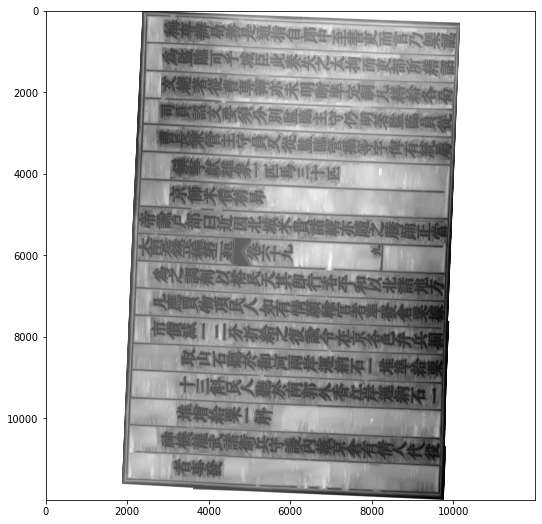

In [12]:
plt.figure(figsize=(12, 9))
plt.imshow(normalized_depth_img, cmap='gray');

In [13]:
depth_image_path = f"{depth_path}/{Path(print_woodblock_path).stem}_vanilla_depth.png"
cv2.imwrite(depth_image_path, normalized_depth_img)

True

4.1.2. With VIA tool, choose 4 corner points to aligned images

### 4.2. Get aligned 3D model

In [14]:
transform_rotated_characters(floor_point_of_woodblock_path, registered_print_woodblock_path, print_woodblock_path, via_2d_3d_mapping_path)

Degree:  -1.5271732254467418


In [9]:
aligned_print_woodblock_path = f'{registered_print_woodblock_path}/{Path(print_woodblock_path).stem}_aligned.stl'

In [10]:
img_inverted_aligned_matrix, normalized_depth_aligned_img = convert_pc_to_depth_map(aligned_print_woodblock_path)

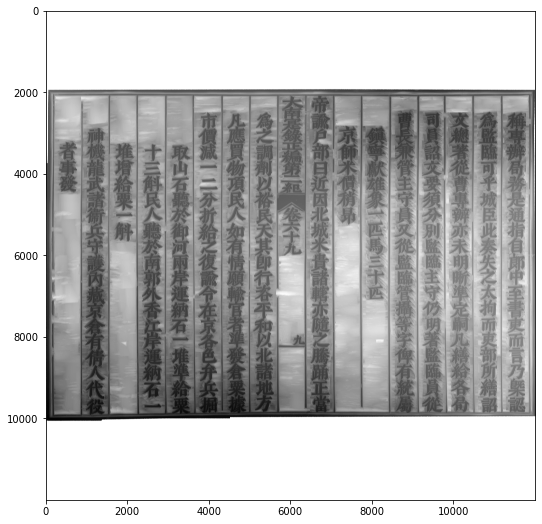

In [11]:
plt.figure(figsize=(12, 9))
plt.imshow(normalized_depth_aligned_img, cmap='gray');

In [18]:
depth_image_path = f"{depth_path}/{Path(print_woodblock_path).stem}_aligned_depth.png"
cv2.imwrite(depth_image_path, normalized_depth_aligned_img)

True

In [19]:
# normalized_depth_aligned_img = cv2.imread(depth_image_path, 0)

### 5. Get the depth map of the whole woodblock

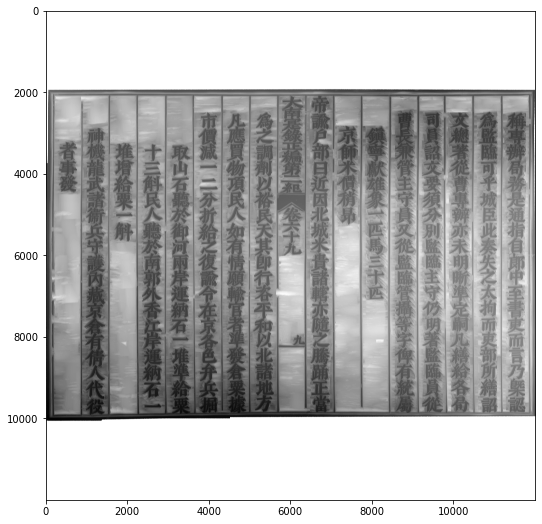

In [20]:
registered_print_woodblock_path  = f'{registered_print_woodblock_path}/{Path(print_woodblock_path).stem}_aligned.stl'
img_inverted_matrix, normalized_depth_img = convert_pc_to_depth_map(registered_print_woodblock_path)
plt.figure(figsize=(12, 9))
plt.imshow(normalized_depth_img, cmap='gray');

In [19]:
# img_inverted_aligned_matrix = img_inverted_matrix
img_inverted_matrix = img_inverted_aligned_matrix

### 6. Mapping labels of 2D print to 3D model

### 7. Mapping the depth map image point to the 3D points with an inverted matrix

In [12]:
def mapping_depth_point_to_3d_point(depth_poly_list, inverted_matrix):
    homo_depth_poly_list = []
    for depth_poly_points in depth_poly_list:
        one_z = np.ones((depth_poly_points.shape[0], 1))
        point_3d = np.c_[depth_poly_points, one_z, one_z]
        homo_depth_poly_list.append(point_3d)
    woodblock_3d_points_list = []
    for homo_depth_poly_point in homo_depth_poly_list:
        point_3d = inverted_matrix@homo_depth_poly_point.T
        point_3d = point_3d.T
        woodblock_3d_points_list.append(point_3d)
    return woodblock_3d_points_list

# def get_rotation_matrix(img, pivot_points):
#     counterwise_lock_degree = get_rad(pivot_points)
#     (h, w) = img.shape[:2]
#     M = cv2.getRotationMatrix2D((w//2, h//2), math.degrees(counterwise_lock_degree), 1.0)
#     return M

# def get_rotation_points(poly_points, M):
#     homo_poly_points = np.column_stack((poly_points, np.ones((len(poly_points), 1))))
#     transform_poly_points = np.dot(M, homo_poly_points.T)
#     transform_poly_points = transform_poly_points.T
#     return transform_poly_points

In [13]:
aligned_2d_3d_mapping_path = "/media/hmi/Expansion/MOCBAN_TEST_OK/register_normalized_2d_and_depth/via_02810_mk9_normalized_depth_print_mapping.json"

In [14]:
[np_src_point_list, np_dest_point_list] = get_point_from_via_file(aligned_2d_3d_mapping_path)
depth_poly_list, origin_poly_list = mapping(via_bboxes_label_path, np_src_point_list, np_dest_point_list)
woodblock_3d_points_list = mapping_depth_point_to_3d_point(depth_poly_list, img_inverted_aligned_matrix)

In [15]:
print_2d = cv2.imread(image_2d_path)
# image = cv2.cvtColor(print_2d, cv2.COLOR_GRAY2BGR)
for index in range(np_src_point_list.shape[0]):
    image = cv2.circle(print_2d, (int(np_src_point_list[index, 0]), int(np_src_point_list[index, 1])), radius=30, color=(0, 0, 255), thickness=-1)

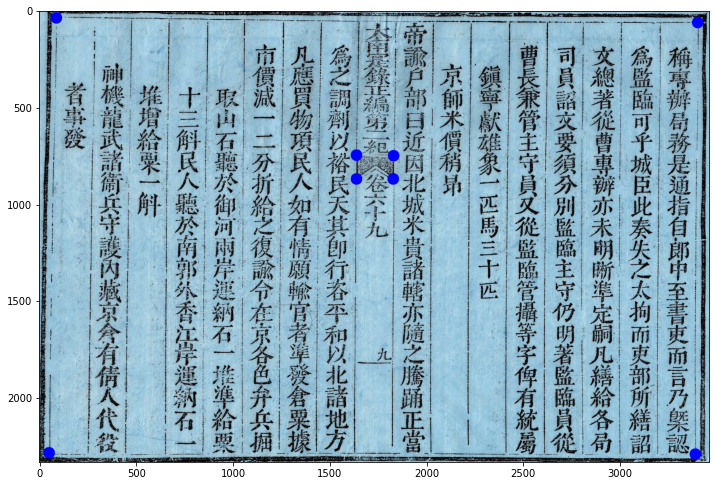

In [16]:
plt.figure(figsize=(12, 9))
plt.imshow(image, cmap='gray')

In [20]:
draw_normalized_depth_img = copy.deepcopy(normalized_depth_aligned_img)
image = cv2.cvtColor(draw_normalized_depth_img, cv2.COLOR_GRAY2BGR)
pivot_depth_point_list = mapping_depth_point_to_3d_point(depth_poly_list, img_inverted_matrix)

for index in range(np_dest_point_list.shape[0]):
    image = cv2.circle(draw_normalized_depth_img, (int(np_dest_point_list[index, 0]), int(np_dest_point_list[index, 1])), radius=100, color=(0, 0, 255), thickness=-1)

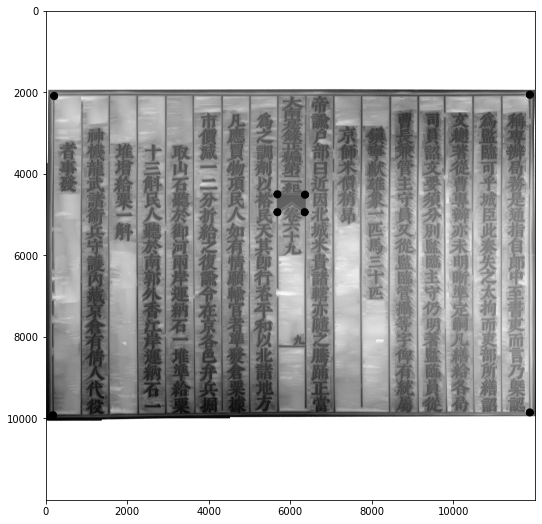

In [21]:
plt.figure(figsize=(12, 9))
plt.imshow(image, cmap='gray')

### 8. Crop character model

In [29]:
# pc_mesh = o3d.io.read_triangle_mesh(registered_print_woodblock_path)

In [24]:
def crop_3d_characters(registered_print_woodblock_path, woodblock_3d_points_list, z_min_bound=-20, z_max_bound=20, save_3d_character=True):
    pc_mesh = o3d.io.read_triangle_mesh(registered_print_woodblock_path)
    character_point_list = []
    character_rect_bound_list = []
    woodblock_id_stem = Path(registered_print_woodblock_path).stem
    for index, poly_points in enumerate(tqdm(woodblock_3d_points_list)):
        min_x, max_x = np.min(poly_points[:, 0]), np.max(poly_points[:, 0])
        min_y, max_y = np.min(poly_points[:, 1]), np.max(poly_points[:, 1])
        min_bound = np.asarray([min_x, min_y, z_min_bound]).reshape(3, 1)
        max_bound = np.asarray([max_x, max_y, z_max_bound]).reshape(3, 1)
        aligned_bb = o3d.geometry.AxisAlignedBoundingBox(min_bound, max_bound)
        character_pc = pc_mesh.crop(aligned_bb)
        character_pc = o3d.geometry.TriangleMesh.compute_triangle_normals(character_pc)
        character_pc = character_pc.remove_duplicated_vertices()
        # np_character_pc = np.asarray(character_pc.vertices)
        character_point_list.append(character_pc)
        character_rect_bound_list.append(np.c_[min_bound, max_bound])
        if save_3d_character:
            Path(f"./character_3d/{woodblock_id_stem}").mkdir(exist_ok=True, parents=True)
            o3d.io.write_triangle_mesh(f'./character_3d/{woodblock_id_stem}/character_{index}.stl', character_pc) 
    return character_point_list, character_rect_bound_list

def crop_polygon_3d_characters(registered_print_woodblock_path, woodblock_3d_points_list, z_min_bound=-25, z_max_bound=25, save_3d_character=True):
    pc_mesh = o3d.io.read_triangle_mesh(registered_print_woodblock_path)
    character_point_list = []
    character_rect_bound_list = []
    woodblock_id_stem = Path(registered_print_woodblock_path).stem
    for index, poly_points in enumerate(tqdm(woodblock_3d_points_list)):
        # print(poly_points.shape)
        bounding_polygon = poly_points[:, :3].astype("float64")
        vol = o3d.visualization.SelectionPolygonVolume()
        vol.orthogonal_axis = "Z"
        vol.axis_max = z_max_bound
        vol.axis_min = z_min_bound
        vol.bounding_polygon = o3d.utility.Vector3dVector(bounding_polygon)
        min_x, max_x = np.min(poly_points[:, 0]), np.max(poly_points[:, 0])
        min_y, max_y = np.min(poly_points[:, 1]), np.max(poly_points[:, 1])
        min_bound = np.asarray([min_x, min_y, z_min_bound]).reshape(3, 1)
        max_bound = np.asarray([max_x, max_y, z_max_bound]).reshape(3, 1)
        # aligned_bb = o3d.geometry.AxisAlignedBoundingBox(min_bound, max_bound)
        character_pc = vol.crop_triangle_mesh(pc_mesh)
        character_pc = o3d.geometry.TriangleMesh.compute_triangle_normals(character_pc)
        character_pc = character_pc.remove_duplicated_vertices()
        # np_character_pc = np.asarray(character_pc.vertices)
        character_point_list.append(character_pc)
        character_rect_bound_list.append(np.c_[min_bound, max_bound])
        if save_3d_character:
            Path(f"./character_3d/{woodblock_id_stem}").mkdir(exist_ok=True, parents=True)
            o3d.io.write_triangle_mesh(f'./character_3d/{woodblock_id_stem}/character_{index}.stl', character_pc) 
    return character_point_list , character_rect_bound_list

In [25]:
# character_point_list, character_rect_bound_list = crop_3d_characters(aligned_print_woodblock_path, woodblock_3d_points_list)
character_point_list, character_rect_bound_list = crop_polygon_3d_characters(aligned_print_woodblock_path, woodblock_3d_points_list)

100%|██████████| 264/264 [21:28<00:00,  4.88s/it]


### 9. Construct 2-degree surfaces

In [26]:
def transform_surface_on_aligned_surface(plane_point_path, woodblock_path):
    pc_plane_points, np_plane_pc_points = read_stl_file(str(plane_point_path))
    pc_points, np_pc_points = read_stl_file(str(woodblock_path))
    transformed_plane_coff = get_character_plane(np_plane_pc_points, order=1)
    transform_matrix = get_transform_matrix(transformed_plane_coff)
    homo_pc_3d = do_transform(np_pc_points, transform_matrix)
    pc_points.vertices = o3d.utility.Vector3dVector(homo_pc_3d)
    pc_points = o3d.geometry.TriangleMesh.compute_triangle_normals(pc_points)
    pc_points.remove_duplicated_vertices()
    return pc_points, homo_pc_3d

In [ ]:
# pc_points, np_pc_points = read_stl_file(surface_point_of_woodblock_path)
# plane_coff_2 = get_character_plane(np_pc_points, order=2)
pc_points, np_pc_points = transform_surface_on_aligned_surface(floor_point_of_woodblock_path, surface_point_of_woodblock_path)
plane_coff_2 = get_character_plane(np_pc_points, order=2)

### 10. Get the normal vector of all characters

In [ ]:
def calculate_direction_normal_vector(C, points):
    gradient_of_x = C[1] + C[4] * points[:, 1] + 2*C[5]*points[:, 0]
    gradient_of_y = C[2] + C[4] * points[:, 0] + 2*C[6]*points[:, 1]
    minus_ones = -np.ones_like(gradient_of_x)
    gradient = np.c_[gradient_of_x, gradient_of_y, minus_ones]
    return np.mean(gradient, axis=0)

def get_position_grid(limit_bounding):
    limit_bounding = limit_bounding.astype(np.int16)
    x = np.arange(limit_bounding[0][0], limit_bounding[0][1])
    y = np.arange(limit_bounding[1][0], limit_bounding[1][1])
    xx, yy = np.meshgrid(x, y)
    position_grid = np.column_stack((xx.ravel(),yy.ravel()))
    return position_grid

def get_all_normal_vectors(character_rect_bound_list, plane_coff_2):
    normal_vector_list = []
    for character_rect_bound in character_rect_bound_list:
        position_grid = get_position_grid(character_rect_bound)
        normal_vector = calculate_direction_normal_vector(plane_coff_2, position_grid)
        normal_vector_list.append(normal_vector)
    return normal_vector_list

In [ ]:
normal_vector_list = get_all_normal_vectors(character_rect_bound_list, plane_coff_2)

### 11. Rotate characters with normal vectors

In [ ]:
def do_character_transform(np_pc_points, transform_matrix):
    ones = np.ones((np_pc_points.shape[0], 1))
    homo_np_pc_points = np.c_[np_pc_points, ones]
    inverted_transform_matrix = np.linalg.inv(transform_matrix)
    homo_pc_3d = inverted_transform_matrix@homo_np_pc_points.T
    # homo_pc_3d = transform_matrix@(homo_np_pc_points.T)
    homo_pc_3d = homo_pc_3d.T[:, :3]
    
    mean_vector = np.mean(homo_pc_3d, axis=0)
    # mean_vector[2] = 0
    homo_pc_3d = homo_pc_3d - mean_vector
    return homo_pc_3d

def calc_u1(a, b, c):
    return b / sqrt(a*a + b*b)


def calc_u2(a, b, c):
    return -a / sqrt(a*a + b*b)

def calc_sin_phi(a, b, c):
    return sqrt((a*a + b*b) / (a*a + b*b + c*c))

def calc_cos_phi(a, b, c):
    return c / sqrt(a*a + b*b + c*c)


def get_rotation_matrix(normalized_vector):
    a, b, c = normalized_vector
    if c < 0:
        a, b, c = -a, -b, -c
    cos_phi = calc_cos_phi(a, b, c)
    sin_phi = calc_sin_phi(a, b, c)
    u1 = calc_u1(a, b, c)
    u2 = calc_u2(a, b, c)
    rot_matrix = np.array([
        [cos_phi + u1 * u1 * (1 - cos_phi)  , u1 * u2 * (1 - cos_phi)           , u2 * sin_phi  ,  0],
        [u1 * u2 * (1 - cos_phi)            , cos_phi + u2 * u2 * (1 - cos_phi) , -u1 * sin_phi ,  0],
        [-u2 * sin_phi                      , u1 * sin_phi                      ,      cos_phi  , 0],
        [0                                  , 0                                 , 0             ,  1]])
    return rot_matrix

def transform_characters(pc_points, normalized_vector, index, save_file=True, dest_dir_path="./character_3d_aligned"):
    np_pc_points = np.asarray(pc_points.vertices)
    transform_matrix = get_rotation_matrix(normalized_vector)
    homo_pc_3d = do_character_transform(np_pc_points, transform_matrix)
    # print(type(homo_pc_3d))
    # pc_points = o3d.geometry.PointCloud()
    # mean_vector = np.mean(np_pc_points, axis=0)
    # mean_vector[2] = 0
    # homo_pc_3d = np_pc_points - mean_vector
    pc_points.vertices = o3d.utility.Vector3dVector(homo_pc_3d)
    pc_points = o3d.geometry.TriangleMesh.compute_triangle_normals(pc_points)
    pc_points.remove_duplicated_vertices()
    if save_file:
        Path(dest_dir_path).mkdir(exist_ok=True, parents=True)
        o3d.io.write_triangle_mesh(f'{dest_dir_path}/{index}_r.stl', pc_points)
    return pc_points

In [ ]:
def get_3d_characters(character_point_list, normal_vector_list, registered_print_woodblock_path):
    aligned_pc_point_list = []
    woodblock_id_stem = Path(registered_print_woodblock_path).stem
    dest_dir_path = f"./character_3d_aligned/{woodblock_id_stem}"
    Path(dest_dir_path).mkdir(exist_ok=True, parents=True)
    for index, character_point in enumerate(tqdm(character_point_list)):
        pc_points = transform_characters(character_point, normal_vector_list[index], index, dest_dir_path=dest_dir_path)
        aligned_pc_point_list.append(pc_points)
    return aligned_pc_point_list

In [ ]:
pc_3d_mesh_list = get_3d_characters(copy.deepcopy(character_point_list), normal_vector_list, registered_print_woodblock_path)

### 12.Create the depth map

In [ ]:
def get_depth_map_imgs(pc_3d_mesh_list, res=(512, 512, 255)):
    depth_map_img_list = []
    img_inverted_matrix_list = []
    for pc_3d_mesh in tqdm(pc_3d_mesh_list):
        img_inverted_matrix, normalized_depth_img = convert_pc_to_depth_map(pc_3d_mesh, res=(512, 512, 255))
        depth_map_img_list.append(normalized_depth_img)
        img_inverted_matrix_list.append(img_inverted_matrix)
    return depth_map_img_list, img_inverted_matrix_list

In [ ]:
depth_map_img_list, img_inverted_matrix_list = get_depth_map_imgs(pc_3d_mesh_list)

### 13. Crop 2d images

In [ ]:
def resize_image_to_square(image, dst=512, color=[255, 255, 255]):
    """
    Resize with padding, first resize image such that max edge get dst, then pad 2 sides of the other edge to dest
    :param image: cv2 image
    :param dst: target size
    :param color: constant pad value
    :return: square image
    """
    desired_size = dst

    im = image
    height, width = im.shape[:2]  # old_size is in (height, width) format

    delta = abs(height - width)
    if height > width:
        top, bottom, left, right = 0, 0, delta // 2, delta - (delta // 2)
    else:
        top, bottom, left, right =  delta // 2, delta - (delta // 2), 0, 0
    color = color
    new_img = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                value=color)
    new_img = cv2.resize(new_img, (dst, dst))
    return new_img


In [ ]:
via_bboxes_label = read_json_file(via_bboxes_label_path)
bboxes_list = parse_sino_nom_bboxes(via_bboxes_label)
img = cv2.imread(image_2d_path)

In [ ]:
def crop_img(img, pts):
    pts = np.array(pts, dtype=np.int32)
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()

    ## (2) make mask
    pts = pts - pts.min(axis=0)

    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)

    ## (4) add the white background
    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg + dst
    dst2 = resize_image_to_square(dst2)
    return dst2

In [ ]:
character_2d_list = []
for bbox in bboxes_list:
    character_2d_list.append(crop_img(img, bbox))

In [ ]:
plt.imshow(character_2d_list[12]);

In [ ]:
plt.imshow(depth_map_img_list[12],cmap='gray');

In [ ]:
woodblock_id_stem = Path(registered_print_woodblock_path).stem
dest_dir_path = f"./character_scan_2d/{woodblock_id_stem}"
Path(dest_dir_path).mkdir(exist_ok=True, parents=True)
for index, character_2d in enumerate(character_2d_list):
    cv2.imwrite(f"{dest_dir_path}/img_{index}.png", character_2d)

In [ ]:

woodblock_id_stem = Path(registered_print_woodblock_path).stem
dest_dir_path = f"./character_depth_imgs/{woodblock_id_stem}"
Path(dest_dir_path).mkdir(exist_ok=True, parents=True)
for index, character_depth in enumerate(depth_map_img_list):
    cv2.imwrite(f"{dest_dir_path}/img_{index}.png", character_depth)